In [ ]:
import os
import zipfile

# Descargar dataset desde Kaggle
dataset_path = "alzheimers_data"
kaggle_dataset = "yiweilu2033/well-documented-alzheimers-dataset"

# Crear la carpeta si no existe
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_path} --unzip")
    print("Dataset descargado y descomprimido en:", dataset_path)
else:
    print("El dataset ya está descargado.")


Dataset descargado y descomprimido en: alzheimers_data


In [ ]:
import os


# Verificar si la ruta del dataset existe
if not os.path.exists(dataset_path):
    print("Error: La ruta del dataset no existe.")
else:
    # Diccionario para almacenar el número de imágenes por clase
    image_counts = {}

    # Recorrer las carpetas dentro del dataset
    for class_name in sorted(os.listdir(dataset_path)):  # Ordenar alfabéticamente
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):  # Verificar que es una carpeta
            num_images = 0

            # Recorrer todos los archivos en la carpeta y sus subcarpetas
            for root, _, files in os.walk(class_path):
                num_images += sum(1 for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')))

            image_counts[class_name] = num_images

    # Mostrar el número de imágenes por clase
    for class_name, count in image_counts.items():
        print(f" {class_name}: {count} imágenes")

    # Mostrar total de imágenes en todo el dataset
    total_images = sum(image_counts.values())
    print(f"\n Total de imágenes en el dataset: {total_images}")


 MildDemented: 5184 imágenes
 ModerateDemented: 376 imágenes
 NonDemented (2): 63560 imágenes
 VeryMildDemented: 13796 imágenes

 Total de imágenes en el dataset: 82916


In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

# Ruta al dataset

# Verificar si la ruta del dataset existe
if not os.path.exists(dataset_path):
    print("Error: La ruta del dataset no existe.")
else:
    # Transformaciones para convertir imágenes a escala de grises y otras modificaciones
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
        transforms.Resize((176, 176)),  # Tamaño esperado
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización en escala de grises
    ])

    # Cargar el dataset utilizando ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

    # Mostrar el número de imágenes en cada clase (para verificar)
    class_names = dataset.classes
    image_counts = {class_name: 0 for class_name in class_names}

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for root, _, files in os.walk(class_path):
                image_counts[class_name] += sum(1 for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')))

    for class_name, count in image_counts.items():
        print(f" {class_name}: {count} imágenes")

    total_images = sum(image_counts.values())
    print(f"\n Total de imágenes en el dataset: {total_images}")

    # División en 80%-10%-10% para entrenamiento, validación y prueba
    train_size = int(0.80 * len(dataset))
    val_size = int(0.10 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    torch.manual_seed(42)  # Para reproducibilidad
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Crear dataloaders
    batch_size = 128
    num_workers = 4

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    # Imprimir tamaños de los conjuntos
    print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


 MildDemented: 5184 imágenes
 ModerateDemented: 376 imágenes
 NonDemented (2): 63560 imágenes
 VeryMildDemented: 13796 imágenes

 Total de imágenes en el dataset: 82916
Train: 66332, Validation: 8291, Test: 8293


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):  # Adaptado a 4 clases
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3)  # (176x176x1) → (174x174x12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=4, kernel_size=3)  # (174x174x12) → (172x172x4)
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3)   # (172x172x4) → (170x170x2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # (170x170x2) → (85x85x2)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(85 * 85 * 2, 16)  # (85x85x2) → (14450) → (16)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, num_classes)  # (16) → (4) ← Adaptado a 4 clases

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # Aplanar antes de FC

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)  # Sin activación final porque CrossEntropyLoss ya lo maneja

        return x

# Inicializar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=4).to(device)


In [ ]:
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
num_epochs = 30  # Ajustar según rendimiento
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Época {epoch+1}/{num_epochs}, "
          f"Pérdida Entrenamiento: {avg_train_loss:.4f}, "
          f"Pérdida Validación: {avg_val_loss:.4f}, "
          f"Precisión Validación: {val_accuracy:.2f}%")

# Guardar el mejor modelo entrenado
torch.save(model.state_dict(), 'best_model.pth')


Época 1/30, Pérdida Entrenamiento: 0.6591, Pérdida Validación: 0.4856, Precisión Validación: 76.70%
Época 2/30, Pérdida Entrenamiento: 0.5253, Pérdida Validación: 0.4599, Precisión Validación: 77.84%
Época 3/30, Pérdida Entrenamiento: 0.5061, Pérdida Validación: 0.4455, Precisión Validación: 78.75%
Época 4/30, Pérdida Entrenamiento: 0.4944, Pérdida Validación: 0.4506, Precisión Validación: 79.58%
Época 5/30, Pérdida Entrenamiento: 0.4903, Pérdida Validación: 0.4356, Precisión Validación: 79.35%
Época 6/30, Pérdida Entrenamiento: 0.4854, Pérdida Validación: 0.4692, Precisión Validación: 80.18%
Época 7/30, Pérdida Entrenamiento: 0.4830, Pérdida Validación: 0.4857, Precisión Validación: 81.23%
Época 8/30, Pérdida Entrenamiento: 0.4810, Pérdida Validación: 0.4302, Precisión Validación: 80.09%
Época 9/30, Pérdida Entrenamiento: 0.4740, Pérdida Validación: 0.4282, Precisión Validación: 80.68%
Época 10/30, Pérdida Entrenamiento: 0.4740, Pérdida Validación: 0.4316, Precisión Validación: 80.20%

<ipython-input-6-5813ceae0666>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
/usr/local/lib/python3.11/dist-packages/t

Reporte de Clasificación:
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       522
ModerateDemented       0.00      0.00      0.00        25
 NonDemented (2)       0.82      1.00      0.90      6356
VeryMildDemented       0.63      0.27      0.38      1390

        accuracy                           0.81      8293
       macro avg       0.36      0.32      0.32      8293
    weighted avg       0.74      0.81      0.75      8293



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


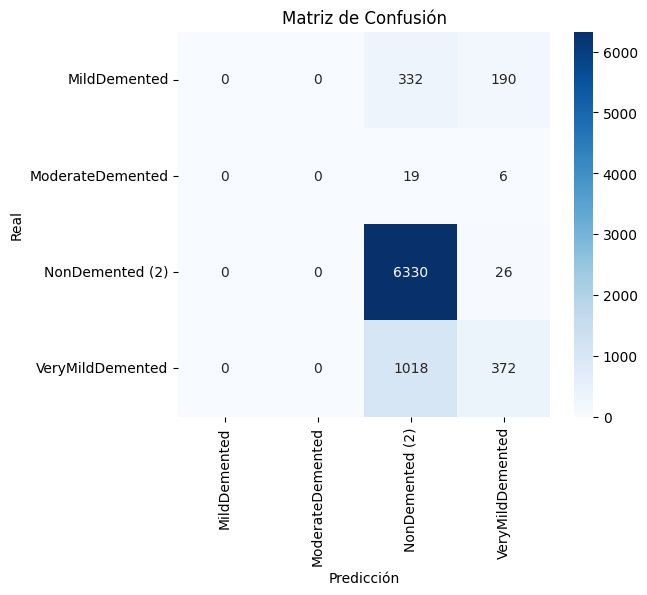

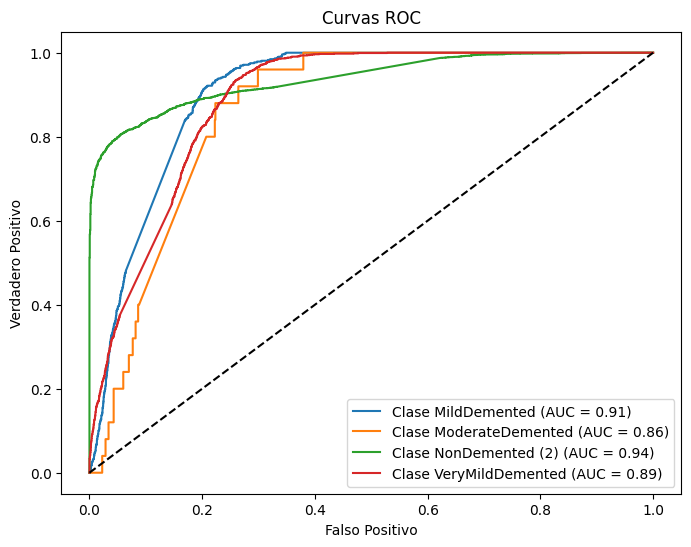

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F

# Cargar modelo entrenado
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Función para obtener predicciones
def get_predictions(model, dataloader):
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Obtener predicciones
y_true, y_pred, y_probs = get_predictions(model, test_loader)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC para cada clase
plt.figure(figsize=(8,6))
for i in range(len(dataset.classes)):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curvas ROC')
plt.legend()
plt.show()
